# Dataset introduction

The dataset chosen for this project is a celeberity dataset. Through this dataset we will be trying to generate faces and with certain attributes like smiling, young, male or female and so on.

We have 4 different files as described below:

1. **img_align_celeba.zip**: All the face images
2. **list_eval_partition.csv**: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing
3. **list_bbox_celeba.csv**: Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box
4. **list_landmarks_align_celeba.csv**: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
5. **list_attr_celeba.csv**: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Neural_Project_Celeba/

In [ ]:
pip install pandas

In [3]:
pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 40.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.8/208.8 MB 14.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 15.9 MB/s eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 40.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 37.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.3 MB/s eta 0:00:00
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 40.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 42.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 41.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442

this is configured to extract data located in my drive, if you're working on the notebook, uncomment the code rashi wrote below. - rutvik
              

In [ ]:
%cd /content/drive/MyDrive/Neural_Project_Celeba/

!unzip img_align_celeba.zip

In [1]:
#Importing zipfile for unzipping the dataset file
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import load_img
from PIL import Image
# from google.colab import drive
from keras.layers import Input, Conv2D, Flatten, Dense
from keras.models import Model
from tensorflow.keras.layers import Dropout, Lambda, Reshape, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

In [9]:
# Mounting Google Drive
drive.mount('/content/drive',force_remount=True)

# drive.flush_and_unmount()

Mounted at /content/drive


In [10]:
# Navigating to the directory containing the zip file
%cd /content/drive/MyDrive/Neural_Project_Celeba/

# Unzipping the file
!unzip img_align_celeba.zip

/content/drive/MyDrive/Neural_Project_Celeba


The below code is for the file where the attributes of each of the image is given and the corresponding values, where 1 indicates a Yes and -1 ondicates a No.

In [4]:
# df_list_attr = pd.read_csv('list_attr_celeba.csv')  ----------> Commented by Rashi, uncomment this if using colab
df_list_attr = pd.read_csv('/Users/rashitiwary/Documents/George Washington University/Masters Subject/CSCI  6366 Neural network/Semester Project/Dataset/list_attr_celeba.csv')
# df_list_attr = pd.read_csv('list_attr_celeba.csv')
df_list_attr.set_index('image_id', inplace=True)
df_list_attr.replace(to_replace=-1, value=0, inplace=True)  # replacing all the attributes of -1 by 0
df_list_attr.shape

(202599, 40)

In [5]:
#Displaying different attributes of the images. In total, there are 40 attributes for each image.
df_list_attr

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202595.jpg,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
202596.jpg,0,0,0,0,0,1,1,0,0,1,...,0,1,1,0,0,0,0,0,0,1
202597.jpg,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


The image below plotted shows different details, and it appears based on whether the details have a '1', meaning 'Yes'. This makes it easier to understand and learn about the different details in the file.

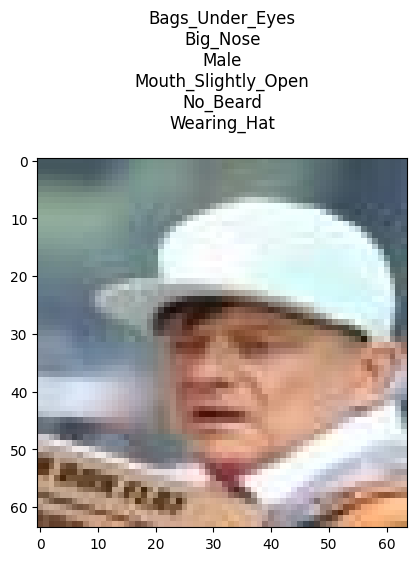

In [6]:
label = ''
img = load_img('/Users/rashitiwary/Documents/George Washington University/Masters Subject/CSCI  6366 Neural network/Semester Project/Dataset/img_align_celeba/img_align_celeba/054810.jpg')
# img = load_img('img_align_celeba/054810.jpg')
row_index = df_list_attr.index.get_loc('054810.jpg')

for col in df_list_attr.columns:
    if df_list_attr.loc['054810.jpg', col] == 1:
        label += col + '\n'

plt.imshow(img)
plt.title(label)
plt.show()

The below block of code is for myself just to check if the files are getting unzipped correctly. Ignore this block of code - Rashi

In [7]:
import os

# Specify the path to your Google Drive folder
folder_path = '/Users/rashitiwary/Documents/George Washington University/Masters Subject/CSCI  6366 Neural network/Semester Project/Dataset/img_align_celeba/img_align_celeba/'

# Get a list of all files in the directory
all_files = os.listdir(folder_path)

# Filter image files (you can customize the list of valid extensions)
image_extensions = ['.jpg', '.jpeg']
image_files = [file for file in all_files if any(file.lower().endswith(ext) for ext in image_extensions)]

# Count the number of image files
num_image_files = len(image_files)

# Print the result
print(f"Number of image files: {num_image_files}")


Number of image files: 202599


In [9]:
# Printing the shape of the image used in previous code cell, before resizing
img_array = np.array(img)
print("Image shape:", img_array.shape)

Image shape: (64, 64, 3)


The below code is of the file list_eval_partition.csv. This file contains the partition of the data in training, validation and testing dataset.

In [10]:
#Overview of list_eval_partition.csv
# df_partition_list = pd.read_csv('list_eval_partition.csv')
df_partition_list = pd.read_csv('/Users/rashitiwary/Documents/George Washington University/Masters Subject/CSCI  6366 Neural network/Semester Project/Dataset/list_eval_partition.csv')
df_partition_list.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [11]:
#Partition columns is defined as follows: 0 for training, 1 for validation and 2 for testing dataset
df_partition_list.groupby('partition').size().sort_index()

partition
0    162770
1     19867
2     19962
dtype: int64

In [18]:
directory_path = '/Users/rashitiwary/Documents/George Washington University/Masters Subject/CSCI  6366 Neural network/Semester Project/Dataset/img_align_celeba/img_align_celeba/'
# directory_path = '/content/drive/MyDrive/img_align_celeba/img_align_celeba'  ----------> Commented by Rashi, uncomment this if using colab
image_list = os.listdir(directory_path)
for image in image_list:

    # Construct the full file path
    image_path = os.path.join(directory_path, image)

    # Open the image using Pillow
    image = Image.open(image_path)

    # Resize the image to (64, 64)
    resized_image = image.resize((64, 64))

    # Save the resized image, overwriting the original file
    resized_image.save(image_path)

In [12]:
#Reshaped the image
# img = load_img('img_align_celeba/081169.jpg')
img = load_img('/Users/rashitiwary/Documents/George Washington University/Masters Subject/CSCI  6366 Neural network/Semester Project/Dataset/img_align_celeba/img_align_celeba/134526.jpg')
img_array = np.array(img)
print("Image shape:", img_array.shape)

Image shape: (64, 64, 3)


In [13]:
#Splitting data into training, validation and testing dataset
#df_partition_list contains the partition of test,training and validation datasets

# directory_path = './img_align_celeba/'
directory_path = '/Users/rashitiwary/Documents/George Washington University/Masters Subject/CSCI  6366 Neural network/Semester Project/Dataset/img_align_celeba/img_align_celeba/'
training_dataset = []
validation_dataset = []
test_dataset = []

for i in df_partition_list['image_id']:
    file_path = directory_path + i
    partition = df_partition_list[df_partition_list['image_id'] == i]['partition'].values[0]
    if partition == 0:
        im = load_img(file_path)
        training_dataset.append(np.array(im))
    elif partition == 1:
        im = load_img(file_path)
        validation_dataset.append(np.array(im))
    elif partition == 2:
        im = load_img(file_path)
        test_dataset.append(np.array(im))

training_data = np.asarray(training_dataset).astype('float32')
validation_data = np.asarray(validation_dataset).astype('float32')
test_data = np.asarray(test_dataset).astype('float32')

training_data = training_data / 255.0
validation_data = validation_data / 255.0
test_data = test_data / 255.0

In [14]:
#Building encoder
latent_dim = 32
input_shape = (64,64,3)

encoder_input = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, kernel_size=3, activation='relu', padding='same')(encoder_input)
x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
# x = Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)

convolution_shape = keras.backend.int_shape(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
# x = Dense(64, activation='relu')(x)

# Parameters for the VAE
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# # Sampling layer
# def sampling(args):
#     z_mean, z_log_var = args
#     batch = tf.shape(z_mean)[0]
#     dim = tf.shape(z_mean)[1]
#     epsilon = tf.random.normal(shape=(batch, dim))
#     return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

class SamplingLayer(layers.Layer):
    def call(self, inputs, **kwargs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Usage
z = SamplingLayer()([z_mean, z_log_var])


# Encoder output
encoder_output = Dense(latent_dim, activation='linear', name='encoder_output')(x)

# Create the encoder model
encoder_model = Model(encoder_input, [z_mean, z_log_var, encoder_output], name='encoder_model')

encoder_model.summary()

Model: "encoder_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 262144)               0         ['conv2d_1[0][0]']            
                                                                                      

In [15]:
# convolution_shape = keras.backend.int_shape(x) 
print(convolution_shape)

(None, 64, 64, 64)


In [16]:
# Decoder
decoder_input = Input(shape = (latent_dim, ), name = 'decoder_input')
x = Dense(convolution_shape[1] * convolution_shape[2] * convolution_shape[3], activation = 'relu')(decoder_input)

# reshaping to the last convolution layer of encoder, so that we can upsacle to the original shape
x = Reshape((convolution_shape[1], convolution_shape[2], convolution_shape[3]))(x)

# Conv2DTranspose to perform the reverse of convolution layers from encoder
x = Conv2DTranspose(64, kernel_size = 3, padding = 'same', activation = 'relu')(x)

#Added to check
x = Conv2DTranspose(32, kernel_size = 3, padding = 'same', activation = 'relu')(x)

# another Conv2DTranspose just for fun, but with sigmoid activation
x = Conv2DTranspose(3, kernel_size = 3, padding = 'same', activation = 'sigmoid', name = 'decoder_output')(x)

# create the decoder model
decoder_model = Model(decoder_input, x, name = 'decoder')

decoder_model.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 32)]              0         
                                                                 
 dense_2 (Dense)             (None, 262144)            8650752   
                                                                 
 reshape (Reshape)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 64, 64, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 64, 64, 32)        18464     
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTran  (None, 64, 64, 3)         867 

In [17]:
z_decoded = decoder_model(z)
print(z_decoded.shape)

(None, 64, 64, 3)


In [18]:
# # Custom Loss for VAE, combination of Reconstruction loss and KL divergence
# class CustomLayer(keras.layers.Layer):

#     def vae_loss(self, x, z_decoded):
#         x = tf.keras.backend.flatten(x)
#         z_decoded = tf.keras.backend.flatten(z_decoded)

#         # Reconstruction loss since we're using sigmoid in the last layer we can use binary-crossentropy
#         recon_loss = tf.keras.metrics.binary_crossentropy(x, z_decoded)

#         # KL divergence
#         kl_loss = -5e-4 * tf.keras.backend.mean(1 + z_decoded - tf.square(z_mean) - tf.exp(z_log_var), axis = -1)
#         return K.mean(recon_loss + kl_loss)

#     def call(self, inputs):
#         x = inputs[0]
#         z_decoded = inputs[1]
#         loss = self.vae_loss(x, z_decoded)
#         self.add_loss(loss, inputs = inputs)
#         return x

# # apply the custom loss to the input images and the decoded latent distribution sample
# y = CustomLayer()([encoder_input, z_decoded])

# print(y)

############################### New code below with slight changes for Custom loss as the above code was throwing TypeError, keeping old code for reference - Rashi #########################
class CustomLayer(tf.keras.layers.Layer):

    def vae_loss(self, x, z_decoded, z_mean, z_log_var):
        x = tf.keras.backend.flatten(x)
        z_decoded = tf.keras.backend.flatten(z_decoded)

        # Reconstruction loss using binary_crossentropy
        recon_loss = binary_crossentropy(x, z_decoded)

        # KL divergence
        kl_loss = -5e-4 * tf.keras.backend.mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)

        return K.mean(recon_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_mean = inputs[2]  # Assuming z_mean is the third input
        z_log_var = inputs[3]  # Assuming z_log_var is the fourth input

        loss = self.vae_loss(x, z_decoded, z_mean, z_log_var)
        self.add_loss(loss, inputs=inputs)
        return x

# Assuming encoder_input, z_decoded, z_mean, and z_log_var are your tensors
y = CustomLayer()([encoder_input, z_decoded, z_mean, z_log_var])

print(y)


KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'custom_layer'")


In [19]:
vae = Model(encoder_input, y)
vae.compile(optimizer = 'adam')
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 262144)               0         ['conv2d_1[0][0]']            
                                                                                              

Trainable params: 25503683 (97.29 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


In [16]:
vae.fit(training_data, None, epochs = 5, batch_size = 32, validation_data = (validation_data, None))

Epoch 1/5
5087/5087 [==============================] - 397s 77ms/step - loss: 0.0014 - val_loss: 6.7498
Epoch 2/5
5087/5087 [==============================] - 550s 108ms/step - loss: 2.1262e-08 - val_loss: 6.7723
Epoch 3/5
5087/5087 [==============================] - 385s 76ms/step - loss: 7.8660e-10 - val_loss: 6.7916
Epoch 4/5
5087/5087 [==============================] - 386s 76ms/step - loss: 6.5820e-11 - val_loss: 6.8009
Epoch 5/5
5087/5087 [==============================] - 566s 111ms/step - loss: -1.2662e-11 - val_loss: 6.8056


624/624 [==============================] - 37s 60ms/step


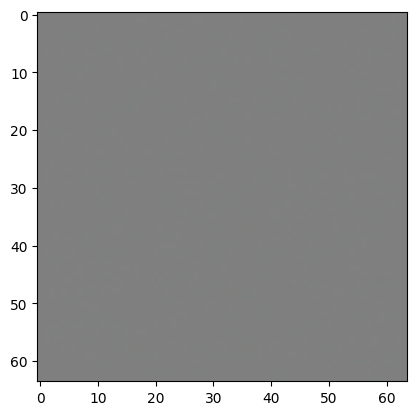

In [20]:
def sample_latent_space(z_mean, z_log_var):
    batch, latent_dim = z_mean.shape
    epsilon = np.random.normal(size=(batch, latent_dim))
    return z_mean + np.exp(0.5 * z_log_var) * epsilon

def get_z_mean_z_log_var(input_image):
    z_mean, z_log_var, _ = encoder_model.predict(input_image)
    return z_mean, z_log_var


z_mean_value, z_log_var_value = get_z_mean_z_log_var(test_data)

latent_vector = sample_latent_space(z_mean_value, z_log_var_value)

generated_image = decoder_model.predict(latent_vector)

plt.imshow(generated_image[0])
plt.show()

In [21]:
# Discriminator model
discriminator_input = Input(shape=(latent_dim,), name='discriminator_input')
x = Dense(64, activation = 'relu')(discriminator_input)
x = Dense(32)(x)
discriminator_output = Dense(1, activation='sigmoid', name='discriminator_output')(x)

discriminator_model = Model(discriminator_input, discriminator_output, name='discriminator_model')

In [22]:
discriminator_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
discriminator_model.summary()

Model: "discriminator_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (Input  [(None, 32)]              0         
 Layer)                                                          
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 discriminator_output (Dens  (None, 1)                 33        
 e)                                                              
                                                                 
Total params: 4225 (16.50 KB)
Trainable params: 4225 (16.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
aae_output = discriminator_model(encoder_model(encoder_input))
aae = Model(inputs=encoder_input, outputs=[vae(encoder_input), aae_output])
aae.compile(optimizer='adam', loss={'vae': 'CustomLayer()', 'discriminator_model': binary_crossentropy})
aae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 encoder_model (Functional)  [(None, 32),                 2518531   ['encoder_input[0][0]']       
                              (None, 32),                 2                                       
                              (None, 32)]                                                         
                                                                                                  
 model (Functional)          (None, 64, 64, 3)            2550368   ['encoder_input[0][0]']       
                                                          3                                 

In [24]:
epochs = 10
batch_size =32 

for epoch in range(epochs):

    print("Starting vae loss")
    # Train the VAE
    vae_loss=vae.fit(training_data, None, batch_size = 32)

    print("Starting generated_samples")
    # Generate fake samples using the VAE
    generated_samples = vae.predict(training_data)

    # Create labels for real and generated samples
    print("Starting real and fake labels")
    real_labels = np.ones((len(training_data), 1))
    fake_labels = np.zeros((len(training_data), 1))

    print("Starting discriminator loss")
    # Train the discriminator with real and generated samples
    discriminator_loss = discriminator_model.fit(np.concatenate([training_data, generated_samples]),np.concatenate([real_labels, fake_labels]))

    # Print or log the losses for monitoring
    print(f'Epoch {epoch + 1}/{epochs}, VAE Loss: {vae_loss["vae"]}, Discriminator Loss: {discriminator_loss}')

Starting vae loss
5087/5087 [==============================] - 1149s 226ms/step - loss: 0.5189
Starting generated_samples
5087/5087 [==============================] - 12s 2ms/step
Starting real and fake labels
Starting discriminator loss


: 